# ML Model for Auto Insurance Industry

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,mean_squared_error,accuracy_score
from sklearn.metrics import precision_score,recall_score,roc_auc_score,f1_score,cohen_kappa_score
from sklearn.utils import resample
from pprint import pprint

import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown, display
import statsmodels.api as sm # import API
from matplotlib.pyplot import xticks

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
py.offline.init_notebook_mode(connected=True)
pd.options.display.float_format = '{:20,.2f}'.format 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##### Data Helper Utilities


In [ ]:
def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))

def get_variable_type(element) :
    """
     Check is columns are of Continuous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then continuous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous"

def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), # data types of columns
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), # total elements in columns
                    'Null_Count': dataframe.isnull().sum().astype(int), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, # percentage of null values
                    'Unique_Values_Count': dataframe.nunique().astype(int) # number of unique values
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

def plot_data_pie_chat(dataframe,col) : 
    header("Stats for "+col+" Datatype Percentage Distribution")
    dataframe_group = dataframe.groupby(col).frequency.count().reset_index()
    dataframe_group.sort_values([col], axis=0,ascending=False, inplace=True)
    trace = go.Pie(labels=dataframe_group[col].tolist(), values=dataframe_group["frequency"].tolist())
    layout = go.Layout(title="Datatype Percentage Distribution")
    fig = go.Figure(data=[trace], layout=layout)    
    py.offline.iplot(fig)

def pairplot(x_axis,y_axis) :
    sns.pairplot(car_df,x_vars=x_axis,y_vars=y_axis,height=4,aspect=1,kind="scatter")
    plt.show()

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

def bar_count_plot(dataframe,col_name) :
    plt.figure(figsize=(16,8))
    plt.title(col_name + 'Histogram')
    sns.countplot(dataframe[col_name], palette=("plasma"))
    xticks(rotation = 90)
    plt.show()

def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def accuracy_result(y_test, y_pred_test):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix, classification_report
    confusion_matrix=metrics.confusion_matrix(y_test, y_pred_test)
    # USE THE IMPORTED CONFUSION MATRIX
    print('\n CONFUSION MATRIX:\n ', confusion_matrix,'\n')
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    false_positive_rate = round(FP / float(TN + FP),3)
    print('FPR: ', false_positive_rate)
    print('TPR/ RECALL/ SENSTIVITY: ', round(metrics.recall_score(y_test, y_pred_test), 3))
    print('PRECISION:' ,round(metrics.precision_score(y_test, y_pred_test), 3))
    specificity = round(TN / (TN + FP),3)
    print('SPECIFICITY: ',specificity)
    print('ACCURACY: ', np.round(metrics.accuracy_score(y_test, y_pred_test),3))
    print('ROC AUC: ', np.round(roc_auc_score(y_test, y_pred_test),3))
    print('Cohens kappa: ',np.round(cohen_kappa_score(y_test, y_pred_test),3))
    print('F1 score: ', np.round(f1_score(y_test, y_pred_test),3))
    print('\n CLASSIFICATION REPORT: \n',classification_report(y_test,y_pred_test))
    return 

In [2]:
!wget 'https://www.dropbox.com/s/r6200m8nuycqaax/train%281%29.csv?dl=0'

--2023-01-21 15:34:04--  https://www.dropbox.com/s/r6200m8nuycqaax/train%281%29.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/r6200m8nuycqaax/train%281%29.csv [following]
--2023-01-21 15:34:04--  https://www.dropbox.com/s/raw/r6200m8nuycqaax/train%281%29.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2023-01-21 15:34:04 ERROR 404: Not Found.



##### Import data

In [ ]:
df = pd.read_csv('/content/train(1).csv?dl=0')
df1= df.copy()
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70,0.20,0.72,10,1,-1,0,1,4,1,0,0,1,12,2,0.40,0.88,0.37,3.61,0.60,0.50,0.20,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80,0.40,0.77,11,1,-1,0,-1,11,1,1,2,1,19,3,0.32,0.62,0.39,2.45,0.30,0.10,0.30,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.00,0.00,-1.00,7,1,-1,0,-1,14,1,1,2,1,60,1,0.32,0.64,0.35,3.32,0.50,0.70,0.10,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.90,0.20,0.58,7,1,0,0,1,11,1,1,3,1,104,1,0.37,0.54,0.29,2.00,0.60,0.90,0.10,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.70,0.60,0.84,11,1,-1,0,-1,14,1,1,2,1,82,3,0.32,0.57,0.37,2.00,0.40,0.60,0.00,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
temp = df[:200000]
_X = temp.drop(['id','target'],axis =1)
_y=temp.target
metadata_matrix_dataframe = get_meta_data(df)
metadata_matrix_dataframe["dt_name"] =[ i.split("_")[-1] for i in metadata_matrix_dataframe.index.values]
metadata_matrix_dataframe['dt_name'] = metadata_matrix_dataframe['dt_name'].apply(lambda x : "interval" if str(x).isnumeric() else x)

In [ ]:
Dtype = metadata_matrix_dataframe.groupby(['dt_name'])

interval_feature =Dtype.get_group("interval").index.tolist()
bin_feature = Dtype.get_group("bin").index.tolist()
cat_feature = Dtype.get_group("cat").index.tolist()

**1. Write at least 3 important inferences from the data above**

**Ans.:**

1. Data is higly imblaced, target distribtion is:
    >0 = 96.36 %
    
    >1 = 3.64 %
    
2. data have vaiable type:
    > Interval = 45.6
    
    > binary =29.8
    
    > categorical = 24.6

3. Most of the features are uncorrelated
    

**2. Is the data balanced? Meaning are targets 0 and 1 in the right proportion?**

**Ans.:** No, data not balanced. I shown below.

Percentge distribution of class '1' & class '0':

 0                  96.36
1                   3.64
Name: target, dtype: float64


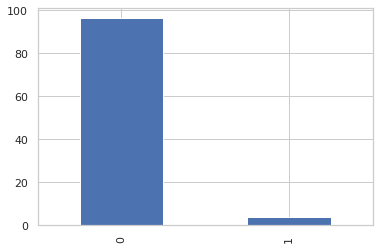

In [ ]:
perc = (df['target'].value_counts()/(df.shape[0]))*100
print("Percentge distribution of class '1' & class '0':\n\n",perc)
perc.plot.bar();

**3. How many categorical features are there?**

In [ ]:
group_variable_type = metadata_matrix_dataframe.groupby('Variable_Type')
print("categorical features count:",group_variable_type.get_group('Categorical').shape[0])

categorical features count: 50


**5. Write inferences from data on interval variables**

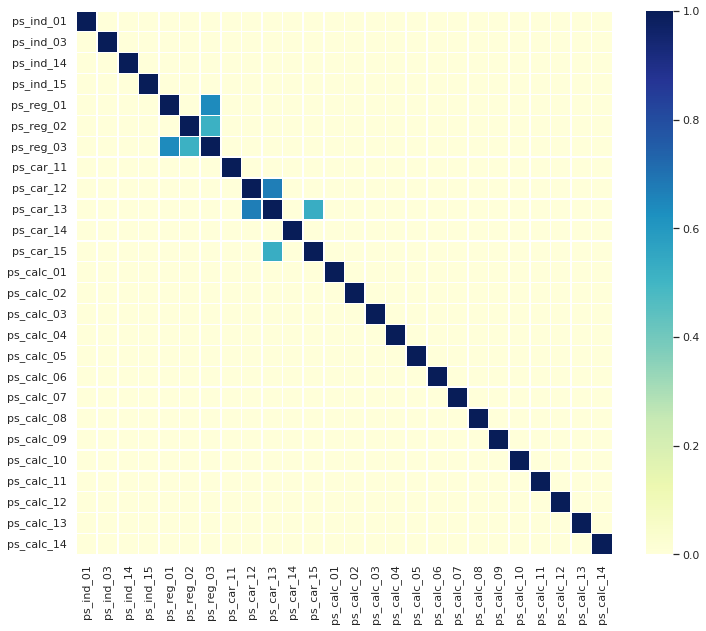

In [ ]:
temp = df[interval_feature].corr()
temp = temp[(temp>=0.5) | (temp<=-0.5)].fillna(0)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(temp,linewidths=.5, cmap="YlGnBu",ax=ax)
plt.show()

In [ ]:
log("Analysis : Almost all the features are independent, Looking at above plot only 3 features are correlated with correlation near 0.5.")

> <span style='color:blue'>Analysis : Almost all the features are independent, Looking at above plot only 3 features are correlated with correlation near 0.5.</span>

**6. Write inferences from data on ordinal variables.**

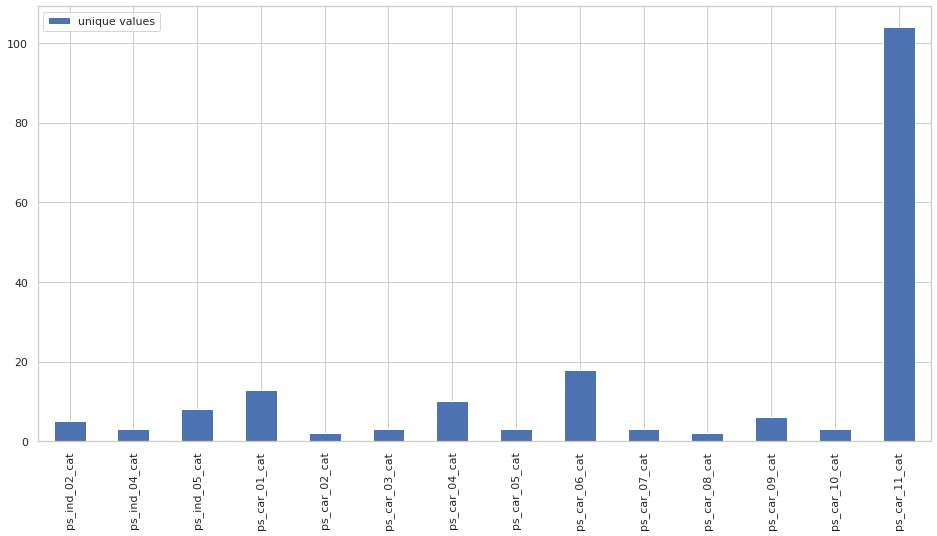

In [ ]:
d ={}
for i in df[cat_feature].columns:
    d[i] = df[cat_feature][i].nunique()

pd.DataFrame(d,index=['unique values']).T.plot.bar(figsize=(16,8));

In [ ]:
log("Analysis : Looking at above graph only one feature have unqiue values more than 20")

> <span style='color:blue'>Analysis : Looking at above graph only one feature have unqiue values more than 20</span>

**7. Write inferences from data on binary variables.**

> <span style='color:blue'>Analysis : Looking at above graph % of 1's is near near for *ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin.</span>

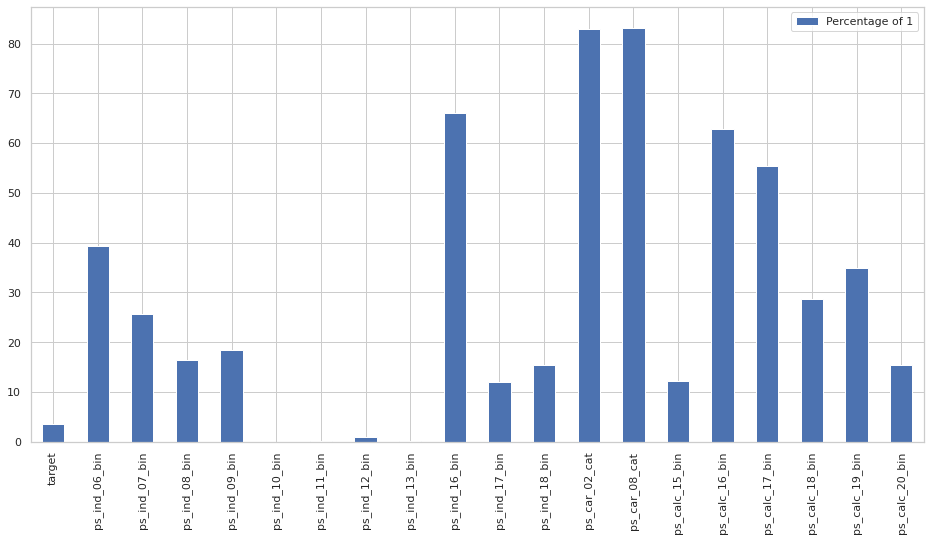

In [ ]:
col = metadata_matrix_dataframe[metadata_matrix_dataframe['Unique_Values_Count'] == 2].index
df_1 = pd.DataFrame((df[col].sum()/df[col].shape[0])*100, columns=['Percentage of 1'])
df_1.plot.bar(figsize=(16,8));
log("Analysis : Looking at above graph % of 1's is near near for *ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin.");

#### 11. Which are the top two features in terms of missing values?

> No Missing Value Found.

#### 12. In total, how many features have missing values?

> No Feature having missing values

#### 13. What steps should be taken to handle the missing data?

> **NA**

#### 8. Check if the target data is proportionate or not. Hint: Below than 30% for binary data is sign of imbalance

Target=1 shape: (21694, 59) 3.64 % 
Target=0 shape: (573518, 59) 96.36 %

 # This Data shows that it's imbalanced


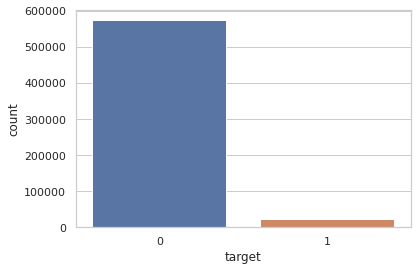

In [ ]:
Per1= np.round((df[df['target']==1].shape[0]*100)/ df.shape[0],2)
Per0= np.round((df[df['target']==0].shape[0]*100)/ df.shape[0],2)

print('Target=1 shape:',df[df['target']==1].shape, Per1,'%','\nTarget=0 shape:',df[df['target']==0].shape,Per0,'%')
print("\n # This Data shows that it's imbalanced")
sns.countplot(x= df['target'])
plt.show()

**9. What should be the preferred way in this case to balance the data?**

> The most popular solution to an imbalanced classification problem is to change the composition of the training dataset.Techniques designed to change the class distribution in the training dataset are generally referred to as sampling methods or resampling methods as we are sampling an existing data sample.



**10. How many training records are there after achieving a balance of 12%?**

In [ ]:
# using resampling technique, splittinf data into classes
df_mino= df[df['target']==1]
df_majo= df[df['target']==0]
df_mino_upsampled = resample(df_mino,replace=True,n_samples=int(len(df_majo)*0.12), random_state = 42)

print("Size of data, after achieving a balance of 12%: ", df_mino_upsampled.shape[0] + df_majo.shape[0])

Size of data, after achieving a balance of 12%:  642340


### Applying Resampling to make balance data-set

Class compostion after resampling:
0    573518
1    573518
Name: target, dtype: int64


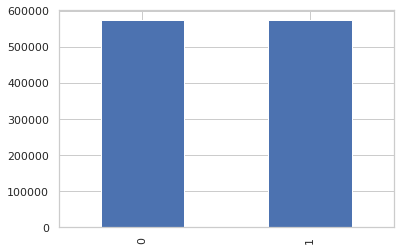

In [ ]:
df_mino_upsampled = resample(df_mino,replace=True,n_samples=len(df_majo), random_state = 42)
df = pd.concat([df_majo,df_mino_upsampled])
print("Class compostion after resampling:")
print(df['target'].value_counts())
df['target'].value_counts().plot.bar();

>Now here we have both class with equall count

#### 14. Which interval variables have strong correlation?

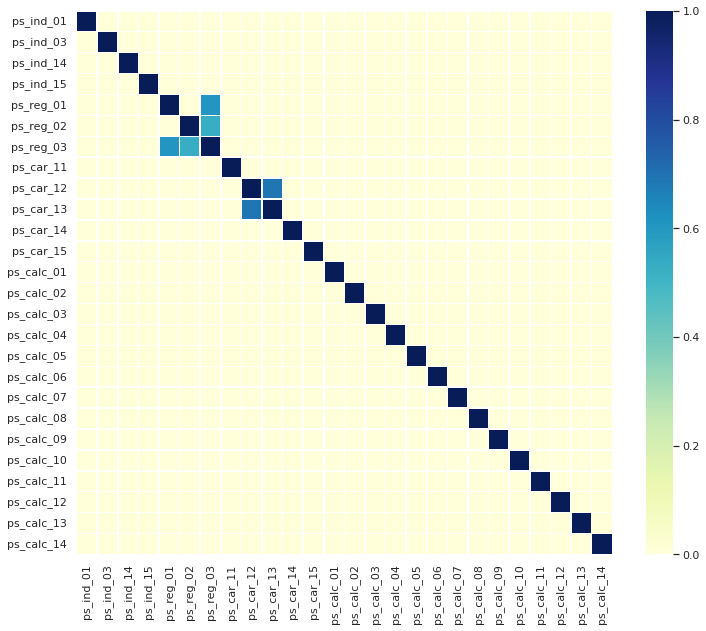

In [ ]:
temp = df[interval_feature].corr()
temp = temp[(temp>=0.5) | (temp<=-0.5)].fillna(0)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(temp,linewidths=.5, cmap="YlGnBu",ax=ax)
plt.show()

> interval Variable with high correlation(abs value more than 0.5)
1. ps_reg_03 --> ps_reg_03 & ps_reg_03
2. ps_reg_13 --> ps_reg_12

#### 15. What's the level of correlation among ordinal features?

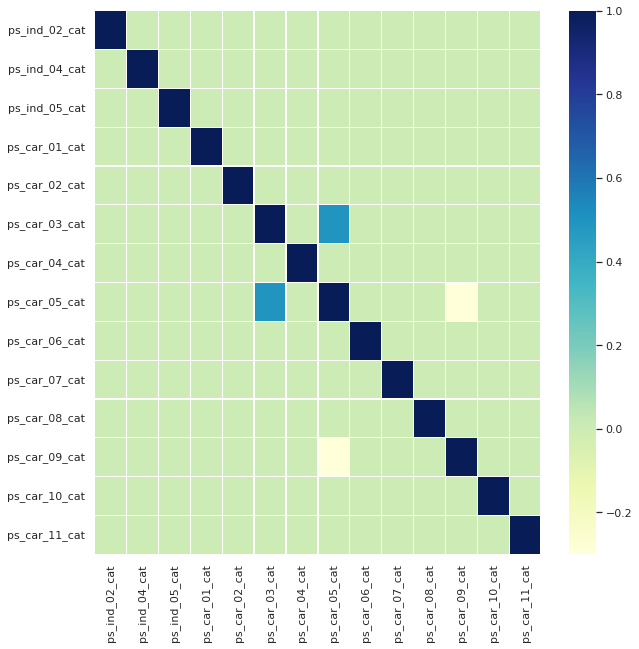

In [ ]:
# cutoff = 0.3
temp = df[cat_feature].corr()
temp = temp[(temp>=0.3) | (temp<=-0.3)].fillna(0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(temp,linewidths=.3, cmap="YlGnBu",ax=ax)
plt.show()

> ordinal Variable with high correlation(abs value more than 0.5)
1. ps_car_03_cat --> ps_car_05_cat
2. ps_car_05_cat --> ps_car_09_cat

#### 16. Implement Hot Encoding for categorical features

**NA**
> No, nominal Features are available

#### 17. In nominal and interval features, which features are suitable for StandardScaler?

>Nominal featues are not suitable for StandardScaler

>We can apply StandardScaler in interval features

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(_X,_y)

feature_imp = pd.Series(clf.feature_importances_,index=_X.columns).sort_values(ascending=False)
imp = pd.DataFrame(feature_imp).reset_index()
imp.columns = ["Features", 'Imp']

imp['Imp'] = (imp['Imp']/max(imp['Imp']))*100
col = imp[imp["Imp"]>25]['Features'].tolist()

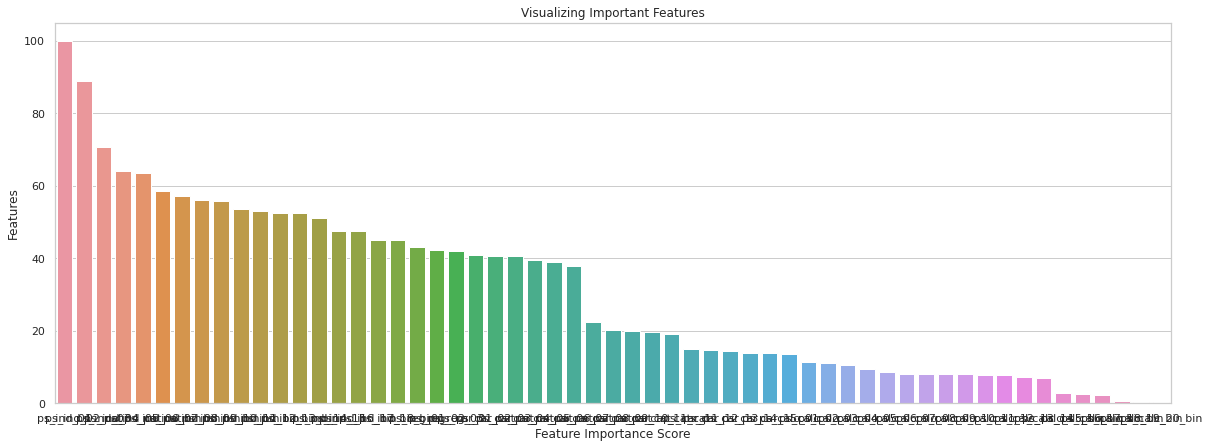

In [ ]:
# Creating a bar plot
plt.figure(figsize = (20,7))
sns.barplot(x=_X.columns, y=imp.Imp)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
print("Top 10 ordered important features")
print(imp[:10].Features);

Top 10 ordered important features
0        ps_car_13
1        ps_reg_03
2        ps_car_14
3       ps_calc_14
4       ps_calc_10
5       ps_calc_11
6    ps_car_11_cat
7        ps_ind_15
8        ps_ind_03
9       ps_calc_01
Name: Features, dtype: object


#### 18. Summarize the learnings of ED

1. Data is higly imblaced, target distribtion is:
    >0 = 96.36 %
    
    >1 = 3.64 %
    
2 Most of the features are uncorrelated

3. Top 10 ordered important features

> 1.    ps_car_13    

> 2.    ps_reg_03    

> 3.    ps_car_14    

> 4.    ps_calc_10   

> 5.    ps_calc_14   

> 6.    ps_calc_11   

> 7.    ps_car_11_cat

> 8.    ps_ind_15    

> 9.    ps_ind_03    

> 10.    ps_calc_01


### Spliting data in feature & target

In [ ]:
x= df.drop(['target','id'], axis=1)
y= df['target']

###  Spliting data in train test
> using 70 percentage for training and 30 percentage for testing

In [ ]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(x, y, test_size = 0.3,random_state = 1)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression (Before Resampling)

In [ ]:
x_= df1.drop(['target','id'], axis=1)
y_= df1['target']

from sklearn.model_selection import train_test_split as tts
X_Train,X_Test,y_Train,y_Test = tts(x_, y_, test_size = 0.3,random_state = 1)

log_reg = LogisticRegression()
log_reg.fit(X_Train, y_Train)

# y_pred_train = log_reg.predict(X_Train)
y_pred_logreg1 = log_reg.predict(X_Test)

accuracy_result(y_Test, y_pred_logreg1)


 CONFUSION MATRIX:
  [[172094      0]
 [  6470      0]] 

FPR:  0.0
TPR/ RECALL/ SENSTIVITY:  0.0
PRECISION: 0.0
SPECIFICITY:  1.0
ACCURACY:  0.964
ROC AUC:  0.5
Cohens kappa:  0.0
F1 score:  0.0

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    172094
           1       0.00      0.00      0.00      6470

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



### Modeling Questions and their Answers 
#### Q. The Simple Logistic Regression Model seems to have high accuracy. Is that what we need at all? What is the problem with this model?
Ans.: Simple Logistic Regression Model seems to have high accuracy because of highly imbalanced data. When we use accuracy, we assign equal cost to false positives and false negatives. When that data set is imbalanced - say it has 96% of instances in one class and only 4 % in the other - there is a great way to lower the cost. Predict that every instance belongs to the majority class, get accuracy of 96% which is very high accuracy.

> Accuracy = (correct classifications / number of classifications)

#### Q. Why do you think f1-score is 0.0?
**Ans.:** In this model, the Precision and Recall both are Zero due to which F1 score also become zero.

#### Q. What is the precision and recall score for the model?
**Ans.:** In this model, the Precision and Recall both are Zero

### Logistic Regression (After Resampling)

#### 1. Fitting a Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

### Logistic Regression (After Resampling)


In [ ]:
## 1. Fitting a Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## 2. Predicting on Train and test data

y_pred_train = log_reg.predict(X_train)
y_pred_logreg2 = log_reg.predict(X_test)

## 3. Using function for evaluating the model output

accuracy_result(y_test, y_pred_logreg2)


 CONFUSION MATRIX:
  [[107904  64389]
 [ 76992  94826]] 

FPR:  0.374
TPR/ RECALL/ SENSTIVITY:  0.552
PRECISION: 0.596
SPECIFICITY:  0.626
ACCURACY:  0.589
ROC AUC:  0.589
Cohens kappa:  0.178
F1 score:  0.573

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.58      0.63      0.60    172293
           1       0.60      0.55      0.57    171818

    accuracy                           0.59    344111
   macro avg       0.59      0.59      0.59    344111
weighted avg       0.59      0.59      0.59    344111



**Q. What is the accuracy score and f1-score for the improved Logistic Regression model?**

**Q. Why do you think f1-score has improved?**

**Ans.:**

**Logistic regression model (Before Resampling)**
* Accurecy = 0.964
* F1 score = 0.0  

**Logistic regression model (After Resampling)**
* Accurecy = 0.589
* F1 score = 0.573

In above given data after resampling the F1 score is 0.573 which is improved F1 score in compare to previous score and it shows improved logistic regression model.

### Support Vector Classifier

In [ ]:
x_tr=X_train[:10000,:]
y_tr=y_train[:10000]

## 1. svm Classifier with linear kernel

#Create a svm Classifier
clf = svm.SVC(kernel='linear')
# FIT SVC ON TRAINING DATA
clf.fit(x_tr, y_tr)

## 2. Predicting on Train and test data

# y_pred_train = clf.predict(X_train)
y_pred_svc = clf.predict(X_test)

#  model output
accuracy_result(y_test, y_pred_svc)


 CONFUSION MATRIX:
  [[111423  60870]
 [ 81580  90238]] 

FPR:  0.353
TPR/ RECALL/ SENSTIVITY:  0.525
PRECISION: 0.597
SPECIFICITY:  0.647
ACCURACY:  0.586
ROC AUC:  0.586
Cohens kappa:  0.172
F1 score:  0.559

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.58      0.65      0.61    172293
           1       0.60      0.53      0.56    171818

    accuracy                           0.59    344111
   macro avg       0.59      0.59      0.58    344111
weighted avg       0.59      0.59      0.58    344111



**Q.: For model LinearSVC play with parameters – dual, max_iter and see if there is any improvement.**

Ans.: Not any Significance Improvement
    
**Q.: SVC with Imbalance Check & Feature Optimization & only 100K Records → is there improvement in scores?**

Ans.: I fitted the SVC model on 10K dataset because on 100K dataset not able to run the model.

### XGBoost Classifier

In [ ]:
## 1. Initializing XGboost Classifier

xg_cls = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 100)
xg_cls.fit(X_train, y_train)

## 2. Predicting on Train and test data

# y_pred_train = xg_cls.predict(X_train)
y_pred_xgb = xg_cls.predict(X_test)

# function for evaluating the model output
accuracy_result(y_test, y_pred_xgb)


 CONFUSION MATRIX:
  [[172287      6]
 [     0 171818]] 

FPR:  0.0
TPR/ RECALL/ SENSTIVITY:  1.0
PRECISION: 1.0
SPECIFICITY:  1.0
ACCURACY:  1.0
ROC AUC:  1.0
Cohens kappa:  1.0
F1 score:  1.0

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    172293
           1       1.00      1.00      1.00    171818

    accuracy                           1.00    344111
   macro avg       1.00      1.00      1.00    344111
weighted avg       1.00      1.00      1.00    344111



**Q. XGBoost is one the better classifiers -- but still f1-score is very low. What could be the reason?**

In my model ,I'm getting f1 score near to 1, that indicate a best fitted model.

**Q. What is the increase in number of features after one-hot encoding of the data?**

Ans.: There is no need of One-hot encoding because it has been previously done.

**Q. Is there any improvement in scores after encoding?**

Ans.: Not happened (because There is no need of One-hot encoding so I have not done it)

**Q. If not missing a positive sample is the priority which model is best so far?**

Ans.:  XGBoost model is performing best.Count of missing positive sample is 6 only.
     
     **XGBoost CONFUSION MATRIX:
     
     [[172287      6]
      
     [     0 171818]]


**Q. If not marking negative sample as positive is top priority, which model is best so far?**

Ans.:  XGBoost model is performing best. No misclassification for negative sample as positive.
     
     **XGBoost CONFUSION MATRIX:
     
     [[172287      6]
      
     [     0 171818]]



### Adaboost classifier

In [ ]:
# Create adaboost classifer object
adaBoost = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)

# Train Adaboost Classifer
model1 = adaBoost.fit(X_train, y_train)


#Predict the response for test dataset
y_pred_ada = model1.predict(X_test)

accuracy_result(y_test, y_pred_ada)


 CONFUSION MATRIX:
  [[106594  65699]
 [ 72948  98870]] 

FPR:  0.381
TPR/ RECALL/ SENSTIVITY:  0.575
PRECISION: 0.601
SPECIFICITY:  0.619
ACCURACY:  0.597
ROC AUC:  0.597
Cohens kappa:  0.194
F1 score:  0.588

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.59      0.62      0.61    172293
           1       0.60      0.58      0.59    171818

    accuracy                           0.60    344111
   macro avg       0.60      0.60      0.60    344111
weighted avg       0.60      0.60      0.60    344111



**Q.: Do you think using AdaBoost can give any significant improvement over XGBoost?**

**Ans.:** No improvement in AdaBoost model result because In my case XGBoost model giving much more better result (Accuracy and F1 score) in compare to AdaBoost model.

### MLP Classifier

In [ ]:
# Training the model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10),activation='logistic', max_iter=200)
mlp.fit(X_train, y_train.values.ravel())

# Prediction on x_test
y_predic = mlp.predict(X_test)
accuracy_result(y_test,y_predic)


 CONFUSION MATRIX:
  [[ 99869  72424]
 [ 61872 109946]] 

FPR:  0.42
TPR/ RECALL/ SENSTIVITY:  0.64
PRECISION: 0.603
SPECIFICITY:  0.58
ACCURACY:  0.61
ROC AUC:  0.61
Cohens kappa:  0.22
F1 score:  0.621

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.62      0.58      0.60    172293
           1       0.60      0.64      0.62    171818

    accuracy                           0.61    344111
   macro avg       0.61      0.61      0.61    344111
weighted avg       0.61      0.61      0.61    344111



**Q.: MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size?**

**Q.: At what layer size we get the best f1-score?**

**Ans.:**

In Generally, you can't analytically calculate the number of layers or the number of nodes to use per layer in an ANN to address a specific real-world predictive modeling problem, But there are many methods for determining the correct number of neurons to use in the hidden layers, such as the following:

 * The no. of hidden neurons should be between the size of the input layer and the size of the output layer.
 * The no. of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
 * The no. of hidden neurons should be less than twice the size of the input layer.

## Final Result Comperison

In [ ]:
data = {'Log_Reg(Before Resamp)':[np.round(f1_score(y_Test, y_pred_logreg1),3), np.round(metrics.accuracy_score(y_Test, y_pred_logreg1),3)],
        'Log_Reg(After Resamp)':[np.round(f1_score(y_test, y_pred_logreg2),3), np.round(metrics.accuracy_score(y_test, y_pred_logreg2),3)],
        'SVC':[np.round(f1_score(y_test, y_pred_svc),3), np.round(metrics.accuracy_score(y_test, y_pred_svc),3)],
        'XGBoost':[np.round(f1_score(y_test, y_pred_xgb),3), np.round(metrics.accuracy_score(y_test, y_pred_xgb),3)],
        'AdaBoost':[np.round(f1_score(y_test, y_pred_ada),3), np.round(metrics.accuracy_score(y_test, y_pred_ada),3)],
        'MLP Classifier':[np.round(f1_score(y_test, y_predic),3), np.round(metrics.accuracy_score(y_test, y_predic),3)]}

df_result=pd.DataFrame(data, index = ['F1_score', 'Accuracy']).T
df_result

,F1_score,Accuracy
Log_Reg(Before Resamp),0.00,0.96
Log_Reg(After Resamp),0.57,0.59
SVC,0.56,0.59
XGBoost,1.00,1.00
AdaBoost,0.59,0.60
MLP Classifier,0.62,0.61


**After comparing the F1- score and Accuracy of all used Machine Learning models, we found that XGBoost model is best performing and giving best result with respect to all other model.**